# Exercise sheet 4

Practice problems for coursework II.

In [1]:
using Plots
using SparseArrays
using LinearAlgebra
using Einsum

In [144]:
new = [CartesianIndex()]
default(size=(600, 300))

## *Method of lines*

Write a program that evolves the **advection equation**

$$
    \partial_t u + c \partial_x u = 0
$$

For initial conditions $u(0, x) = f(x)$. Suppose $f(x) = \exp(-16x^2)$

In [90]:
f(x) = exp(-16x^2)

f (generic function with 1 method)

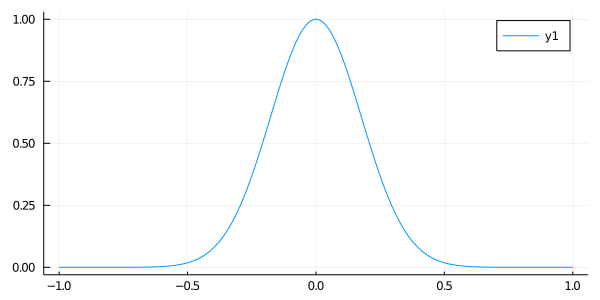

In [91]:
Δt = 0.01
trange = -1:Δt:1
plot(trange, f.(trange))

We will discretize the pde as follows

$$
\frac{d{\bf u}}{dt} = c \mathbb{D}{\bf u}
$$

Which implies that the change in the system becomes

$$
{\bf u}(t_{n+1}) - {\bf u}(t_{n}) = \int_{t_n}^{t_{n+1}} \mathbb{D}{\bf u}(t) dt
$$

In [92]:
"""
# Build a differentiation matrix

This function builds a differentiation matrix required to compute
a second-order finite-differences method assuming equidistant points
"""
function build_diff_matrix(x_grid, Δx)
    n_grid = length(x_grid)
    D = spzeros(n_grid, n_grid)
    
    for row in 1:n_grid
        if row == 1
            # Left-difference formula
            D[row, row] = -3
            D[row, row + 1] = 4
            D[row, row + 2] = -1
        elseif row == n_grid
            # Right-difference formula
            D[row, row - 2] = 1
            D[row, row - 1] = -4
            D[row, row] = 3
        else
            # Central-difference formula
            D[row, row - 1] = -1
            D[row, row] = 0
            D[row, row + 1] = 1
        end
    end
    
    D = D ./ 2Δx
    return D
end


"""
# 2nd order finite-differences

Compute the 2nd order difference's method 
assuming a set of equidistant points
"""
function finite_differences(f, x_grid, Δx)
    D = build_diff_matrix(x_grid, Δx)
    fvals = f.(x_grid)
    f_prime_approx = D * fvals
    
    return f_prime_approx
end

finite_differences

#### A small review: finite-differences

In order to compute the derivative using the 2nd-order finite-differences' method, we only require to compute the *fixed* derivative matrix $D$ and evaluate the set of observed points at the given function

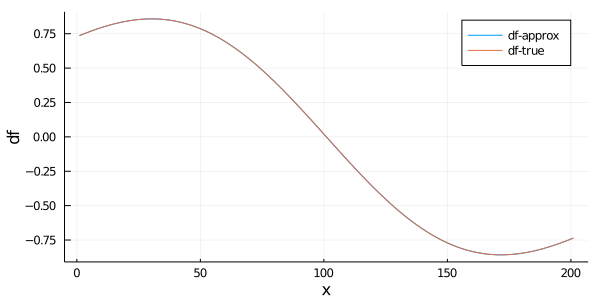

In [93]:
f(x) = exp(-x ^ 2.0)
f_prime(x) = -2.0 * exp(-x ^ 2.0)x

f_prime_vals = finite_differences(f, trange, Δt)
f_prime_true = f_prime.(trange)

plot(f_prime_vals, label="df-approx")
plot!(f_prime_true, label="df-true", ylabel="df", xlabel="x")

----

### TVD-RK2

$$
    u(0, x) = f(x)
$$

In [94]:
f(x) = exp(-16x^2)

f (generic function with 1 method)

In [364]:
c = -1
Δt = 0.01
xrange = -1:Δt:1
nvals = length(xrange)
D = build_diff_matrix(xrange, Δt)
D[[begin], :] .= 0
#D[[end], :] .= 0
L = c * D
M = I + Δt * L + Δt ^ 2 / 2 * L ^ 2;

In [365]:
U_old = f.(xrange)
nsteps = 100
U_matrix = zeros(nsteps, nvals)

U_matrix[1, :] = U_old
for ti=2:nsteps
    U_new = M * U_old
    U_matrix[ti, :] = U_new
    U_old = U_new
end

U_matrix;

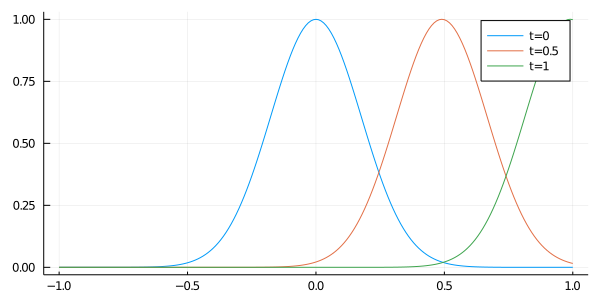

In [366]:
plot(xrange, U_matrix[1, :], label="t=0")
plot!(xrange, U_matrix[50, :], label="t=0.5")
plot!(xrange, U_matrix[100, :], label="t=1")

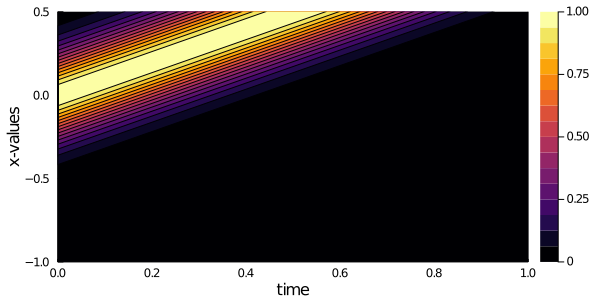

In [367]:
contourf(range(0, 1, length=100), xrange, transpose(U_matrix), xlabel="time", ylabel="x-values", ylim=(-1, 0.5))

### Trapezium rule

In [385]:
c = -1
Δt = 0.005
Δx = 0.01
xrange = -1:Δx:1
nvals = length(xrange)
D = build_diff_matrix(xrange, Δx)
D[[begin], :] .= 0 
#D[[end], :] .= 0 # c <= 1
L = c * D
M = I + Δt * L + Δt ^ 2 * L ^ 2;

In [386]:
M0 = I - Δt * L / 2 + (Δt ^ 2) * L ^ 2
M1 = I + Δt * L / 2 + (Δt ^ 2) * L ^ 2;

In [387]:
function trapezium_integrate(nsteps, xrange, f, M0, M1)
    U_old = f.(xrange)
    nvals = length(xrange)
    U_matrix = zeros(nsteps, nvals)
    
    U_matrix[1, :] = U_old
    for ti=2:nsteps
        # Efficient only for finite-differences
        U_new = M0 \ (M1 * U_old)
        U_matrix[ti, :] = U_new
        U_old = U_new
    end
    
    return U_matrix
end

trapezium_integrate (generic function with 1 method)

In [388]:
t_end = 1
nsteps = ceil(Int, t_end / Δt) + 1
U_trapezium = trapezium_integrate(nsteps, xrange, f, M0, M1);

In [389]:
#spy(M1, size=(400, 400))

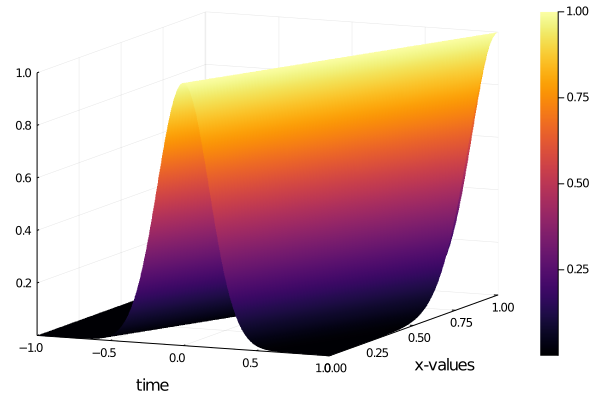

In [390]:
t_max = Δt * nsteps
trange = range(0, t_max, length=nsteps)
surface(xrange, trange, U_trapezium, xlabel="time", ylabel="x-values", size=(600, 400))

* What exactly is the Pade approximation
* For schrödinger's eq, det(H) = 1. Why do we care about symmetry or anti-symmetry?

In [395]:
# exact solution for the advection equation for c = 1
u(t, x) = f(x - t)

u (generic function with 1 method)

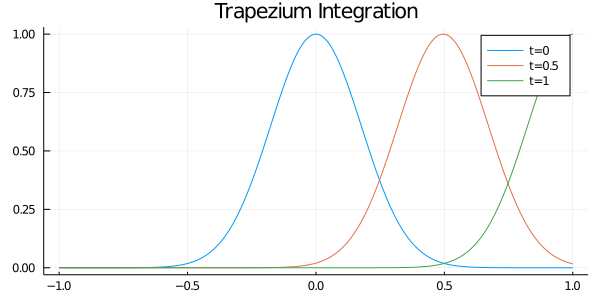

In [396]:
plot(xrange, transpose(U_trapezium[[begin, ceil(Int, 0.5 / Δt), end], :]),
    label=["t=0" "t=0.5" "t=1"], title="Trapezium Integration")

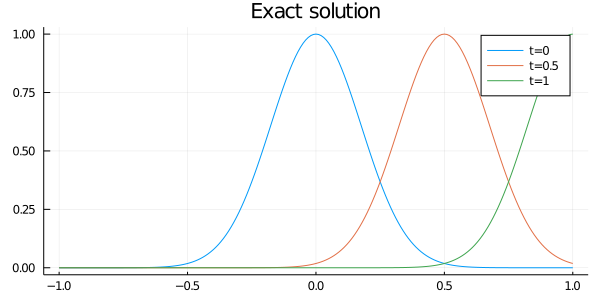

In [397]:
plot(xrange, u.([0 0.5 1], xrange[:, new]),
    label=["t=0" "t=0.5" "t=1"], title="Exact solution")

To verify that our numerical solution converges to the correct answer, we evaluate and graph the norm

$$
    l_1(t) = \int |u_\text{numerical}(t, x) - u_\text{analytical}(t, x)| dx
$$

We will approximate the integral using the trapezium rule

In [398]:
# trapezium-rule weights
trange = 0:Δt:1

0.0:0.005:1.0

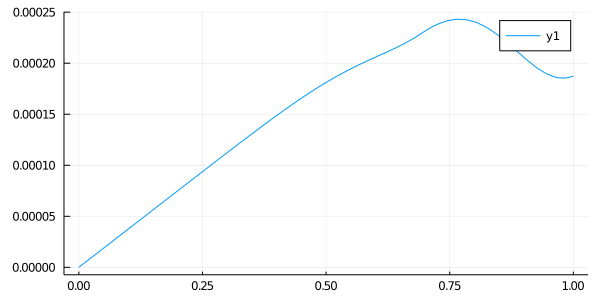

In [399]:
w_trapezium = Δt * ones(length(xrange))
w_trapezium[[begin, end]] .= w_trapezium[[begin, end]] ./ 2

errs = abs.(u.(trange[:, new], xrange[new, :]) .- U_trapezium);
@einsum Iv[t] := w_trapezium[x] * errs[t, x]
plot(trange, Iv)